In [1]:
import pandas as pd
import itertools
from itertools import chain
from collections import Counter
from matplotlib import pyplot as plt
import json
import numpy as np

In [2]:
mon = pd.read_csv('AIES-2022-lightning-monday.csv')
tues = pd.read_csv('AIES-2022-lightning-tuesday.csv')
student = pd.read_csv('AIES-2022-student-lightning.csv')
keynote = pd.read_csv('AIES-2022-keynote.csv')

In [ ]:
mon_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(mon.loc[:,mon.columns[1:]].values.tolist())))
tues_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(tues.loc[:,tues.columns[1:]].values.tolist())))
student_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(student.loc[:,student.columns[1:]].values.tolist())))
keynote_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(keynote.loc[:,keynote.columns[1:]].values.tolist())))

In [44]:
def org_hist(org_list):
    orgs, cnts = zip(*Counter(org_list).most_common())
    plt.figure(figsize=(5, 0.3 * len(orgs)))
    plt.yticks(fontsize=12)
    plt.barh(orgs, cnts)
    plt.gca().invert_yaxis()

In [45]:
def country_pie(org_list, agg_ones=True, one_x=0.7, one_y=-0.2):
    with open('org_country.json', 'r') as f:
        org_countries = json.load(f)
    countries = {}
    for country, orgs in org_countries.items():
        cnt = 0
        for org in orgs:
            cnt += org_list.count(org)
        if cnt > 0:
            countries[country] = cnt
    if 'Company' in countries.keys():
        del(countries['Company'])
    countries_sorted, cnts_sorted = zip(*sorted(countries.items(), key=lambda item: item[1], reverse=True))
    print(cnts_sorted)

    def my_autopct(pct, data):
        absolute = int(np.round(pct/100.*np.sum(data)))
        return "{:.1f}%\n({:d})".format(pct, absolute) if absolute > 1 or agg_ones==False else ''

    plt.figure(figsize=(10, 10))
    if agg_ones:
        plt.text(one_x, one_y, "{:.1f}%\n({:d})".format(100 / sum(cnts_sorted), 1) , fontsize=20)
    plt.pie(cnts_sorted, 
            labels=countries_sorted, 
            autopct=lambda pct: my_autopct(pct, cnts_sorted), 
            textprops={'fontsize': 15},
            pctdistance=0.7,
            labeldistance=1.2
    )
    plt.show()


In [46]:
all_talks = mon_inst + tues_inst + student_inst + keynote_inst

(47, 23, 12, 10, 4, 4, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1)


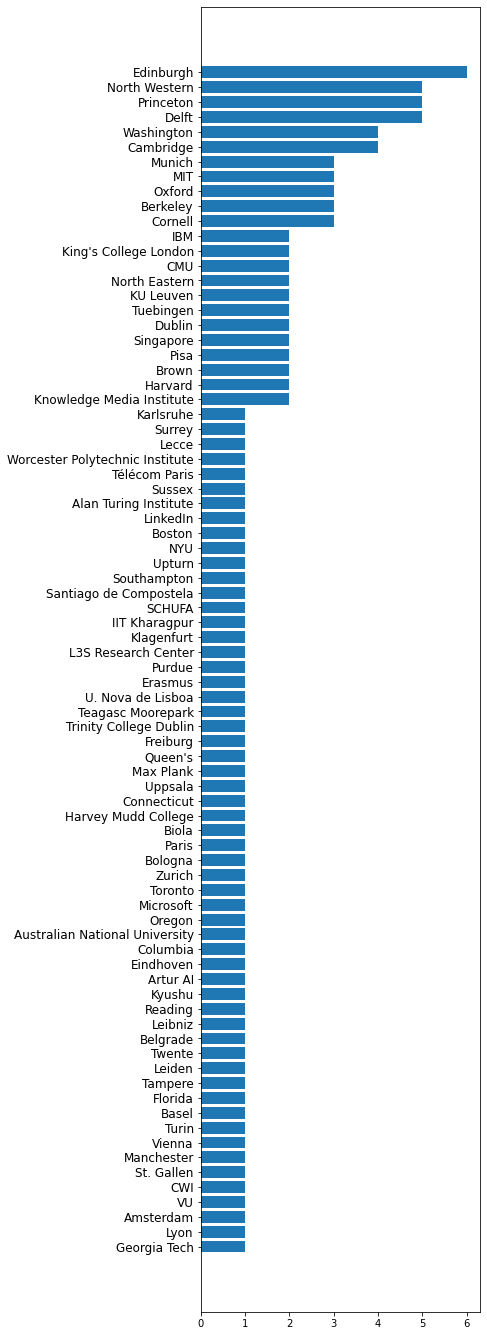

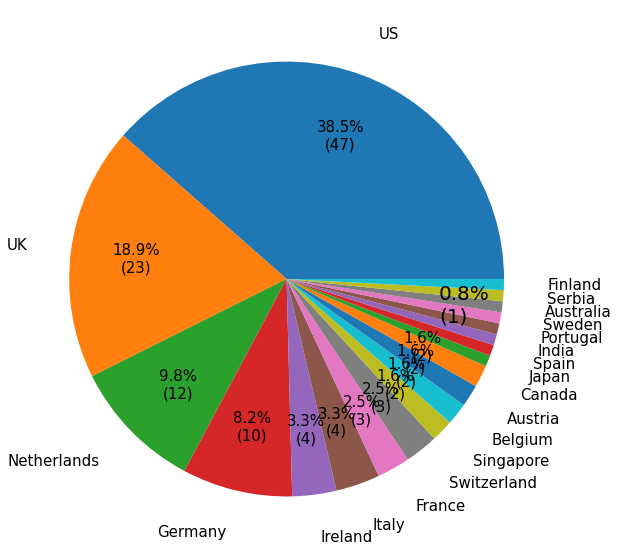

In [47]:
org_hist(all_talks)
country_pie(all_talks)

(36, 14, 8, 4, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1)


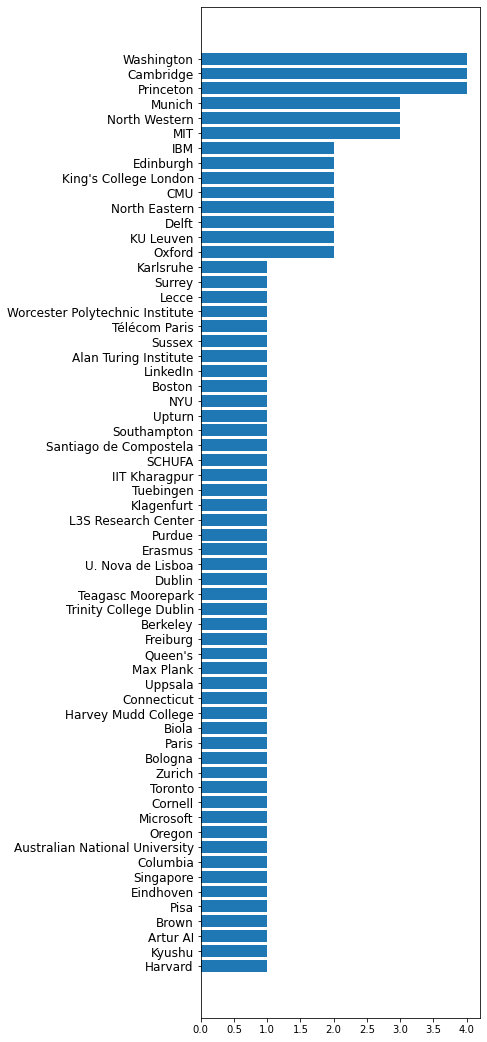

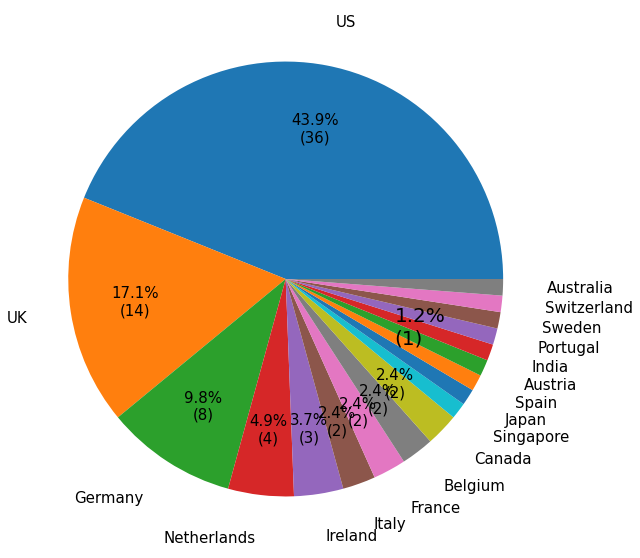

In [48]:
org_hist(mon_inst + tues_inst)
country_pie(mon_inst + tues_inst, one_x=0.5 , one_y=-0.3)

(8, 8, 7, 2, 2, 2, 1, 1, 1, 1, 1, 1)


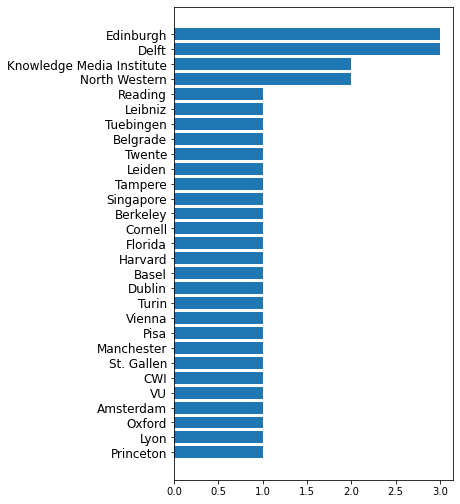

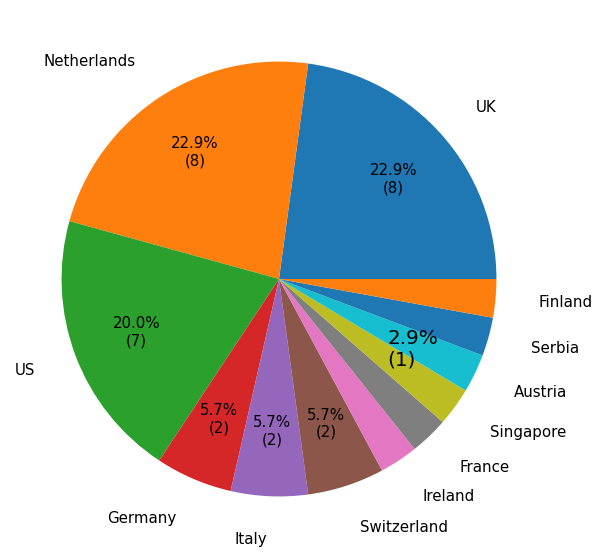

In [49]:
org_hist(student_inst)
country_pie(student_inst, one_x=0.5, one_y=-0.4)

(4, 1)


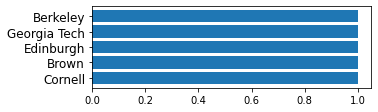

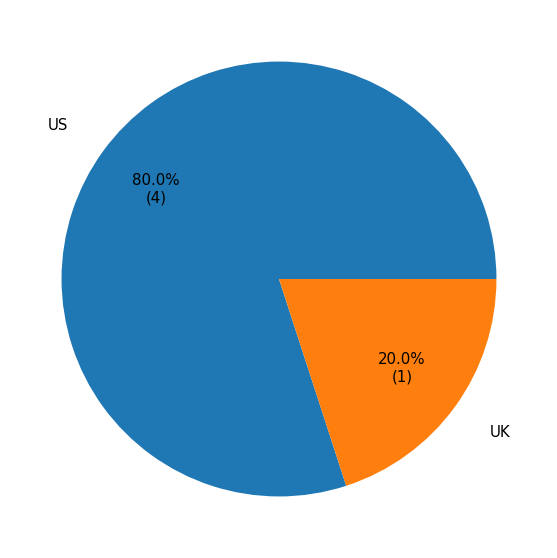

In [50]:
org_hist(keynote_inst)
country_pie(keynote_inst, False)

In [51]:
print(len(mon_inst))
print(len(tues_inst))
print(len(student_inst))
print(len(keynote_inst))

44
41
35
5
